# Classifying pulmonary diseases using chest X rays 

<b>Contact info</b>
<br>
<b>Name:</b> Mardja Bueno, Ph.D.
<br>
<b>email:</b> mardja.bueno@gmail.com
<br>

## 1. Overview and goals

In the medical field, one of the most promising areas of innovation is the application of machine learning in medical imaging.

Chest X ray images currently are the most realiable method for diagnosing lung diseases.

In this project, a large set of chest X-ray images will be used to build a model that detects and classifies lungs infected with tuberculosis, pneumonia or COVID-19.

## 2. The dataset

For that we will use the dataset available on Kaggle (https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis?select=train) contains 3 folders (train, test, val) for each image category (Normal/Pneumonia/Covid-19/Tuberculosis), with a total of 7135 x-ray images present.

But first, we need to import all the necessary libraries.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import os
 
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
 
import warnings
warnings.filterwarnings('ignore')

Now we will load the image folders

In [2]:
# create path for the folders where the training, test and validation images are
train_folders = 'Chest X ray images/train/' 
test_folders = 'Chest X ray images/test/'
val_folders = 'Chest X ray images/val/'

# create empty lists for train, test and val
total_train = {}
total_test = {}
total_val = {}

# iterate through the length of the list
for folder in os.listdir(train_folders):
    if not folder.startswith('.'): # so it doesn't open the .DS Store folder on Mac
        total_train[folder] = len(os.listdir(train_folders + folder))
    
for folder in os.listdir(test_folders):
    if not folder.startswith('.'):
        total_test[folder] = len(os.listdir(test_folders + folder))
    
for folder in os.listdir(val_folders):
    if not folder.startswith('.'):
        total_val[folder] = len(os.listdir(val_folders + folder))

# sum the number of images in each list
quantity_train = pd.DataFrame(list(total_train.items()), index = range(0,len(total_train)), columns = ['class','count'])
quantity_test = pd.DataFrame(list(total_test.items()), index = range(0,len(total_test)), columns = ['class','count'])
quantity_val = pd.DataFrame(list(total_val.items()), index = range(0,len(total_val)), columns = ['class','count'])

# print how many images we have in each dataset
print("Number of images in the training dataset : ", sum(total_train.values()))
print("Number of images in the testing dataset : ",sum(total_test.values()))
print("Number of images in the validation dataset : ",sum(total_val.values()))

Number of images in the training dataset :  6326
Number of images in the testing dataset :  771
Number of images in the validation dataset :  38


With this, we can observe that we have a total of 6326 images in the training folders, 771 in the testing folders and 38 in the validation folders. We can also plot those numbers for each category.

## 3. Exploratory data analysis

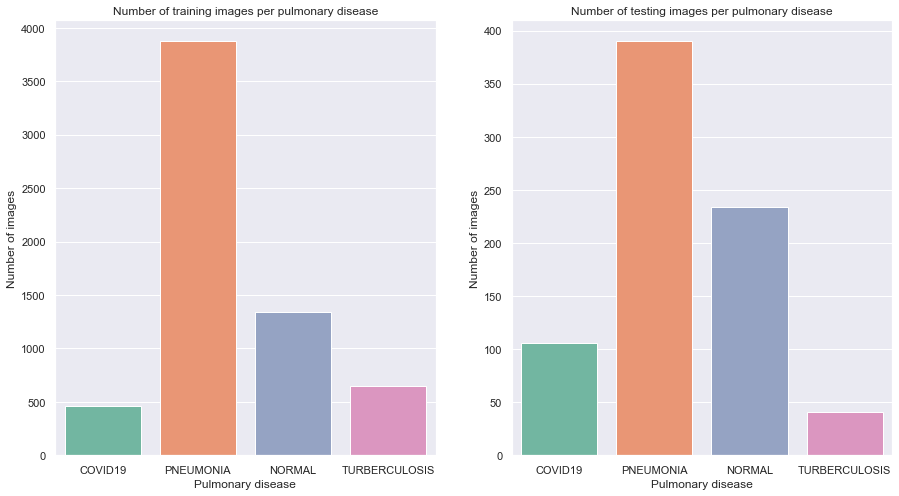

In [3]:
# create bar plots with the number of training and testing
# images in each folder per pulmonary disease
figure, ax = plt.subplots(1,2, figsize = (15,8))

sns.set_palette("Set2")

sns.barplot(x = 'class',y = 'count',data = quantity_train,ax = ax[0])
sns.barplot(x = 'class',y = 'count',data = quantity_test,ax = ax[1])


# set titles and labels
ax[0].set_title('Number of training images per pulmonary disease')
ax[0].set(xlabel = 'Pulmonary disease', ylabel = 'Number of images')

ax[1].set_title('Number of testing images per pulmonary disease')
ax[1].set(xlabel = 'Pulmonary disease', ylabel = 'Number of images')

plt.show()

We can also plot specific images for each one of the diseases.

In [4]:
# load images with the Keras API
from tensorflow.keras.utils import load_img, img_to_array

def sample_image(sample_image_path):
    img = load_img(sample_image_path)
    print((img_to_array(img)).shape)
    plt.imshow(img)
    plt.show()

(1294, 1168, 3)


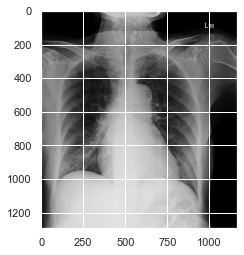

In [5]:
sample_image_path = train_folders+"/COVID19/COVID19(22).jpg"
sample_image(sample_image_path)

(1430, 1762, 3)


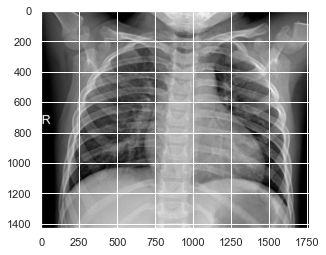

In [6]:
sample_image_path = train_folders+"/NORMAL/IM-0162-0001.jpeg"
sample_image(sample_image_path)

(1056, 1248, 3)


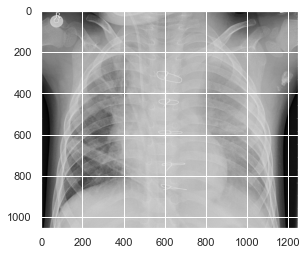

In [7]:
sample_image_path = train_folders+"/PNEUMONIA/person3_bacteria_10.jpeg"
sample_image(sample_image_path)

(512, 512, 3)


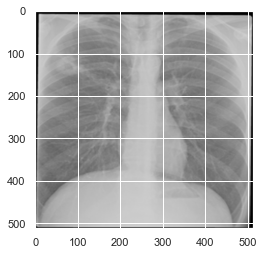

In [8]:
sample_image_path = train_folders+"/TURBERCULOSIS/Tuberculosis-12.png"
sample_image(sample_image_path)

## 4. Data preprocessing

Now, before building our model, we need to augment our images. This is a necessary pre-processing technique that helps the model to generalize the unseen data well. For that, we will use the ImageDataGenerator class.

In [9]:
# folders paths
train_path = 'Chest X ray images/train/'

In [10]:
# use tensorflow for the data augmentation and preprocessing
# split data into 80% training and 20% validation
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 
                 )
 
train_generator = gen.flow_from_directory(
    directory = train_path, 
    subset="training",
    color_mode="rgb",
    target_size = (331,331), 
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)
 
validation_generator = gen.flow_from_directory(
    directory = train_path, 
    subset="validation",
    color_mode="rgb",
    target_size = (331,331),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 5061 images belonging to 4 classes.
Found 1265 images belonging to 4 classes.


We can now see what our augmented images look like.

In [11]:
x,y = next(train_generator)
x.shape

(32, 331, 331, 3)

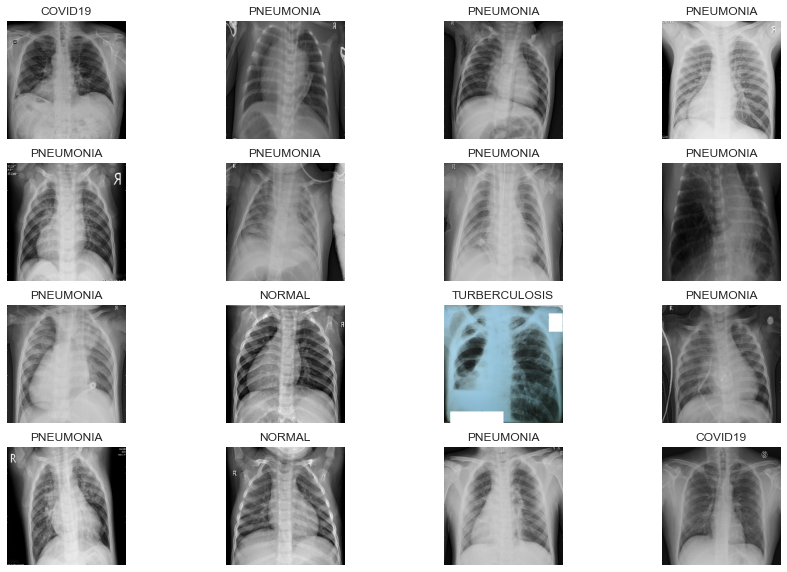

In [12]:
a = train_generator.class_indices

# store class names in a list
class_names = list(a.keys()) 

def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
 
plot_images(x,y)

## 5. Building the model with transfer learning

Building a model from scratch can result in limited performance, as the model has to first learn learn how to detect generic features in the images, such as edges and blobs of color, before detecting more complex features. Because of that reason, we will use a transfer learning approach and reuse a pretrained model that has already been trained in a large dataset of images.

In this project we will use the InceptionResNetV2, which is a 164 layers deep convolutional neural network thas has been trained on millions of images from the ImageNet database, and can classify images into more than 1000 categories. 

In [13]:
# load the InceptionResNetV2 architecture
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )

# freeze the layer = its internal state will not change during training and weights will not be updated when fitting
base_model.trainable=False
 
model = tf.keras.Sequential([
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax') # for the 4 classes present
    ])

A few important techniques used to build this model are:

* <b>BatchNormalization:</b>  a normalization technique which is done along mini-batches instead of the full data set. It is used to speed up training and use higher learning rates.

* <b>GlobalAveragePooling2D:</b>  reduces the dimensionality of the images by reducing the number of pixels in the output from the previous neural network layer.

* <b>Dense Layers:</b>  are regular fully connected neural network layers connected after the convolutional layers.

* <b>Drop out layer:</b> function is to randomly drop some neurons from the input unit so as to prevent overfitting. The value of 0.5 indicates that 0.5 fractions of neurons have to be dropped.


Now, before training our model we first need to compile it, which defines the loss function, optimizers, and metrics for prediction.

In [14]:
# categorical cross entropy = used as a loss function for multi-class classification problems
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

And then display a summary report of our model.

In [15]:
# get summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 9, 9, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

We will now define callbacks to preserve the best results. Callback is an object that can perform actions at various stages of training (for example, at the start or end of an epoch, before or after a single batch, etc).

In [16]:
# set early stopping call back
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

Now we will train the model in our dataset.

In [17]:
batch_size=32

# hyperparameters
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
 
# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15,
                    callbacks=[early])

Epoch 1/15
158/158 [==============================] - 1780s 11s/step - loss: 0.3571 - accuracy: 0.8584 - val_loss: 0.1603 - val_accuracy: 0.9391
Epoch 2/15
158/158 [==============================] - 1715s 11s/step - loss: 0.1875 - accuracy: 0.9338 - val_loss: 0.1812 - val_accuracy: 0.9279
Epoch 3/15
158/158 [==============================] - 1717s 11s/step - loss: 0.1272 - accuracy: 0.9547 - val_loss: 0.1148 - val_accuracy: 0.9599
Epoch 4/15
158/158 [==============================] - 1714s 11s/step - loss: 0.0963 - accuracy: 0.9676 - val_loss: 0.1316 - val_accuracy: 0.9615
Epoch 5/15
158/158 [==============================] - 1719s 11s/step - loss: 0.0777 - accuracy: 0.9732 - val_loss: 0.1017 - val_accuracy: 0.9663
Epoch 6/15
158/158 [==============================] - 1716s 11s/step - loss: 0.0703 - accuracy: 0.9755 - val_loss: 0.1183 - val_accuracy: 0.9639
Epoch 7/15
158/158 [==============================] - 1710s 11s/step - loss: 0.0523 - accuracy: 0.9821 - val_loss: 0.1866 - val_ac

## 6. Model evaluation

To evaluate our model, we can use the 'evaluate' function and also plot the leearning curves

In [18]:
# evaluate the model
model.evaluate(validation_generator,steps = STEP_SIZE_VALID)

39/39 [==============================] - 337s 9s/step - loss: 0.1060 - accuracy: 0.9679


[0.10602875053882599, 0.9679487347602844]

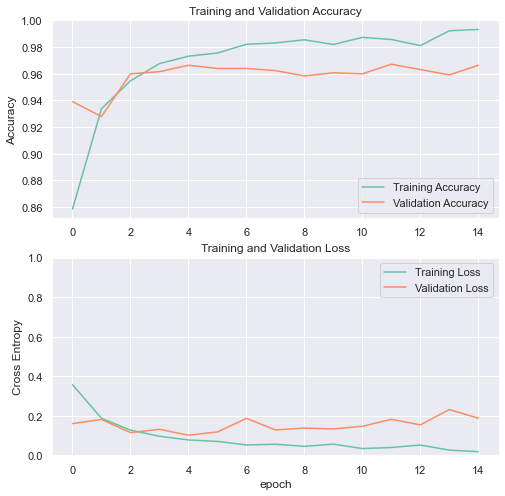

In [19]:
# plot learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We visualized the model’s performance by plotting a line graph of training vs validation accuracy and loss. The graph indicates that the accuracies of validation and training were almost consistent with each other and above 90%.

Finally, we will save our model.

In [20]:
# save the model
model.save("XrayImageClassifier.h5")

## 7. Conclusions

In this project we were able to:

* Import a total of 6326 training images, 771 testing images and 38 validation images

* Augment images using the ImageDataGenerator class

* Build a model based on InceptionResNetV2 that classifies chest X-ray images into 4 classes (normal, tuberculosis, pneumonia or COVID-19) with 96.8% accuracy